In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import time
print(torch.__version__)

1.12.1


In [2]:
%matplotlib inline
torch.manual_seed(0)


In [3]:
def dtwtorch(exp_data, num_data):
    r"""
    Compute the Dynamic Time Warping distance.
    
    exp_data : torch tensor N x P
    num_data : torch tensor M x P
    """
    c = torch.cdist(exp_data, num_data, p=2)
    d = torch.empty_like(c)
    d[0, 0] = c[0, 0]
    n, m = c.shape
    for i in range(1, n):
        d[i, 0] = d[i-1, 0] + c[i, 0]
    for j in range(1, m):
        d[0, j] = d[0, j-1] + c[0, j]
    for i in range(1, n):
        for j in range(1, m):
            d[i, j] = c[i, j] + min((d[i-1, j], d[i, j-1], d[i-1, j-1]))
    return d[-1, -1]


In [4]:
# get experimental data
x1 = np.linspace(0,1.0,num=100)
xEnd = np.log((1.0 + (2.0*np.exp(1.0)) - np.exp(1.0))/2.0)
x2 = np.linspace(1.0,xEnd, num=50)

y1 = np.exp(x1) - 1.0
y2 = 2*np.exp(x2) - 2.0*np.exp(1.0) + np.exp(1.0) - 1.0
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))

exp_data = np.zeros((len(x), 2))
exp_data[:, 0] = x
exp_data[:, 1] = y

exp_data = torch.from_numpy(exp_data)

In [5]:
# define numerical model

class NumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        betas = torch.nn.Parameter(torch.tensor([1.5, -1.5, 2.0, 2.0]))
        self.register_parameter('betas', betas)
        self.register_buffer('x1', torch.linspace(0, 1, 100))
        xEnd = np.log((1.0 + (2.0*np.exp(1.0)) - np.exp(1.0))/2.0)
        self.register_buffer('x2', torch.linspace(1.0, xEnd, 50))
        

    def forward(self):
        y = torch.empty((150, 2), dtype=self.betas.dtype, device=self.betas.device)
        y[:100, 1] = torch.exp(self.betas[0]*self.x1) + self.betas[1]
        y[100:, 1] = 2.0*torch.exp(self.betas[2]*self.x2) - 2.0*torch.exp(self.betas[3]) + np.exp(1.0) - 1.0
        y[:100, 0] = self.x1
        y[100:, 0] = self.x2
        return y

In [6]:
model = NumModel().double()

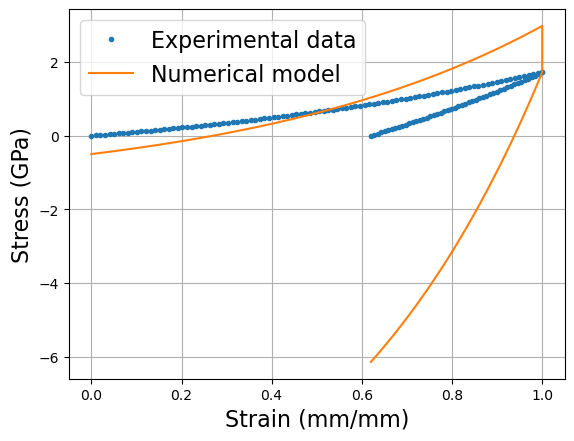

In [7]:
# plot sample outputs
with torch.no_grad():
    num_data = model()
plt.figure()
plt.plot(exp_data[:, 0], exp_data[:, 1], '.', label='Experimental data')
plt.plot(num_data[:, 0], num_data[:, 1], '-', label='Numerical model')
plt.grid(True)
plt.xlabel('Strain (mm/mm)', fontsize=16)
plt.ylabel('Stress (GPa)', fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [8]:
print('initial dtw distance', dtwtorch(exp_data, num_data))


initial dtw distance tensor(181.0964, dtype=torch.float64)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
lmbda = lambda epoch: 0.99
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0)
for t in range(1000):
    t0 = time()
    # Forward pass of the model
    num_data = model()

    # Compute the dtw loss
    loss = dtwtorch(exp_data, num_data)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    t1 =  time()
    if t % 1 == 0:
        print(t, loss.item(), t1-t0, scheduler.get_last_lr())

0 181.0963600836811 1.3137145042419434 [0.099]
1 114.30538334031836 1.3164467811584473 [0.09801]
2 105.35630849105426 1.4083573818206787 [0.0970299]
3 111.02453651116477 1.403062343597412 [0.096059601]
4 107.6314307498145 1.4228935241699219 [0.09509900499]
5 95.85245670091734 1.4449238777160645 [0.0941480149401]
6 84.35276251209876 1.4381763935089111 [0.093206534790699]
7 73.99183635426874 1.4511003494262695 [0.09227446944279201]
8 66.90704069882563 1.4346270561218262 [0.09135172474836409]
9 63.784140506177465 1.438981294631958 [0.09043820750088044]
10 63.71365441346665 1.4429066181182861 [0.08953382542587164]
11 63.894057998917916 1.454115629196167 [0.08863848717161292]
12 61.619850621995994 1.4706811904907227 [0.08775210229989679]
13 55.72454296994877 1.431835412979126 [0.08687458127689782]
14 48.23516309543106 1.4590873718261719 [0.08600583546412884]
15 41.32413848153443 1.4550340175628662 [0.08514577710948755]
16 35.89399305336098 1.4912919998168945 [0.08429431933839267]
17 32.1286

132 2.4154032980357436 1.4496991634368896 [0.026271258725022874]
133 2.9140112014968182 1.4609224796295166 [0.026008546137772644]
134 3.1227451882517188 1.452505111694336 [0.025748460676394917]
135 2.9015600210204124 1.4342496395111084 [0.025490976069630966]
136 2.332412223783636 1.4634547233581543 [0.025236066308934657]
137 1.5873490647956383 1.4569435119628906 [0.02498370564584531]
138 1.2994079488624801 1.4882028102874756 [0.024733868589386858]
139 1.6966066557195478 1.538830280303955 [0.02448652990349299]
140 2.0618908114625243 1.448946237564087 [0.02424166460445806]
141 2.455323369829767 1.447779655456543 [0.02399924795841348]
142 2.596282019523569 1.4620115756988525 [0.023759255478829344]
143 2.462752574335798 1.4624533653259277 [0.02352166292404105]
144 2.209294340579407 1.4703798294067383 [0.02328644629480064]
145 1.803387364687567 1.5027027130126953 [0.023053581831852635]
146 1.3442671451476338 1.5981297492980957 [0.022823046013534107]
147 1.3233257129452158 1.4849190711975098

260 0.6118143949395086 1.5481557846069336 [0.007257479035344943]
261 0.6849252684415074 1.5070455074310303 [0.007184904244991494]
262 0.523391588226369 1.451460599899292 [0.007113055202541579]
263 0.7544438354335482 1.4306762218475342 [0.007041924650516163]
264 0.859805579840369 1.45975661277771 [0.006971505404011002]
265 0.7351648815906012 1.564272165298462 [0.006901790349970892]
266 0.5013999663184096 1.5705976486206055 [0.006832772446471183]
267 0.5785886082920396 1.5152432918548584 [0.006764444722006471]
268 0.47646197370123816 1.5207891464233398 [0.006696800274786406]
269 0.5180276362572573 1.5265612602233887 [0.006629832272038541]
270 0.5576558455921634 1.4917666912078857 [0.006563533949318156]
271 0.5018114174086419 1.4913768768310547 [0.006497898609824975]
272 0.6584806530913916 1.470632791519165 [0.006432919623726724]
273 0.6827569039694008 1.4780702590942383 [0.006368590427489457]
274 0.5201326683453116 1.5204589366912842 [0.006304904523214563]
275 0.6815228933051616 1.616686

387 0.46721529287317043 1.5882000923156738 [0.0020251421078849325]
388 0.5140280967317136 1.5035133361816406 [0.002004890686806083]
389 0.5248908154000069 1.5342040061950684 [0.001984841779938022]
390 0.48294721169696997 1.5211057662963867 [0.0019649933621386415]
391 0.5158669209286687 1.517704963684082 [0.001945343428517255]
392 0.5440521828366258 1.5013668537139893 [0.0019258899942320826]
393 0.5191736645275761 1.5611772537231445 [0.0019066310942897618]
394 0.46280002168622786 1.4766559600830078 [0.0018875647833468641]
395 0.47763008242500876 1.4926118850708008 [0.0018686891355133954]
396 0.4679158046087736 1.5111002922058105 [0.0018500022441582614]
397 0.4590300696014188 1.4985363483428955 [0.0018315022217166787]
398 0.4839525238905567 1.5843992233276367 [0.001813187199499512]
399 0.46616455368891613 1.467625617980957 [0.0017950553275045168]
400 0.50635079438326 1.4993350505828857 [0.0017771047742294716]
401 0.5158737369367798 1.525137186050415 [0.001759333726487177]
402 0.479082026

512 0.45836207942254903 1.5053372383117676 [0.0005765737000977047]
513 0.46276861405027025 1.5118722915649414 [0.0005708079630967276]
514 0.4570472628989009 1.4728808403015137 [0.0005650998834657603]
515 0.4588646369757233 1.512521743774414 [0.0005594488846311027]
516 0.46038873879165493 1.5631351470947266 [0.0005538543957847917]
517 0.45839877545870383 1.4653146266937256 [0.0005483158518269438]
518 0.45830565100434395 1.5067338943481445 [0.0005428326933086744]
519 0.45865482703733657 1.4748506546020508 [0.0005374043663755876]
520 0.4602107511077596 1.504248857498169 [0.0005320303227118317]
521 0.4579576865086787 1.4856224060058594 [0.0005267100194847134]
522 0.45836788623572233 1.5376086235046387 [0.0005214429192898663]
523 0.4582615680604003 1.5225775241851807 [0.0005162284900969677]
524 0.46048259729283036 1.43955397605896 [0.000511066205195998]
525 0.45633557883045905 1.4759860038757324 [0.000505955543144038]
526 0.4580836688511636 1.4400012493133545 [0.0005008959877125976]
527 0.4

636 0.45657228631908847 1.4309046268463135 [0.00016581314574010565]
637 0.4580792206194473 1.4504618644714355 [0.00016415501428270458]
638 0.45790340932476714 1.4501514434814453 [0.00016251346413987753]
639 0.45675667339425047 1.4380626678466797 [0.00016088832949847875]
640 0.4587886039772665 1.4408705234527588 [0.00015927944620349396]
641 0.4572196123953895 1.4457430839538574 [0.000157686651741459]
642 0.4577790974369901 1.4373939037322998 [0.00015610978522404443]
643 0.45856718813360253 1.44545316696167 [0.000154548687371804]
644 0.45621195202585857 1.4314968585968018 [0.00015300320049808596]
645 0.4589085391234384 1.4449219703674316 [0.0001514731684931051]
646 0.4590979427457325 1.4417016506195068 [0.00014995843680817405]
647 0.4563942378067386 1.4464366436004639 [0.0001484588524400923]
648 0.4591722505368323 1.457015037536621 [0.00014697426391569138]
649 0.45949351045082776 1.449695110321045 [0.00014550452127653446]
650 0.45655986209711097 1.4376397132873535 [0.00014404947606376912

760 0.4556073378034746 1.4339427947998047 [4.768514293241345e-05]
761 0.45615493842083105 1.4419746398925781 [4.720829150308932e-05]
762 0.45568811822736977 1.4406678676605225 [4.673620858805843e-05]
763 0.4562436174526843 1.4607939720153809 [4.626884650217784e-05]
764 0.4565033365459581 1.4442541599273682 [4.580615803715606e-05]
765 0.4556930125240625 1.5130176544189453 [4.53480964567845e-05]
766 0.4563040837368546 1.4543483257293701 [4.4894615492216656e-05]
767 0.45660783405744404 1.436758279800415 [4.444566933729449e-05]
768 0.4558163025185706 1.4469523429870605 [4.400121264392155e-05]
769 0.4563376508504305 1.485334873199463 [4.356120051748233e-05]
770 0.45686158155987017 1.4750242233276367 [4.312558851230751e-05]
771 0.45629871371488334 1.5453639030456543 [4.269433262718443e-05]
772 0.45562232151248155 1.4424920082092285 [4.2267389300912586e-05]
773 0.4561122347005682 1.4516897201538086 [4.184471540790346e-05]
774 0.45556038515239466 1.4485011100769043 [4.142626825382442e-05]
775 

883 0.45574385843283444 1.4577207565307617 [1.3851985371392195e-05]
884 0.4552908173055841 1.4336800575256348 [1.3713465517678273e-05]
885 0.45583037835041884 1.4696776866912842 [1.357633086250149e-05]
886 0.4561580298921398 1.4923176765441895 [1.3440567553876475e-05]
887 0.45613521443262006 1.5090432167053223 [1.3306161878337711e-05]
888 0.4558034346325087 1.5168328285217285 [1.3173100259554333e-05]
889 0.4552413672345137 1.463998794555664 [1.304136925695879e-05]
890 0.45578953158321844 1.432790994644165 [1.2910955564389202e-05]
891 0.4560152705402937 1.469294786453247 [1.278184600874531e-05]
892 0.4559171869286207 1.4511656761169434 [1.2654027548657856e-05]
893 0.4555337130583561 1.4378821849822998 [1.2527487273171277e-05]
894 0.455497342501396 1.4648776054382324 [1.2402212400439565e-05]
895 0.4557726133408212 1.4328827857971191 [1.2278190276435169e-05]
896 0.4557307183641363 1.4380874633789062 [1.2155408373670817e-05]
897 0.45540924380251385 1.4375393390655518 [1.2033854289934109e-0

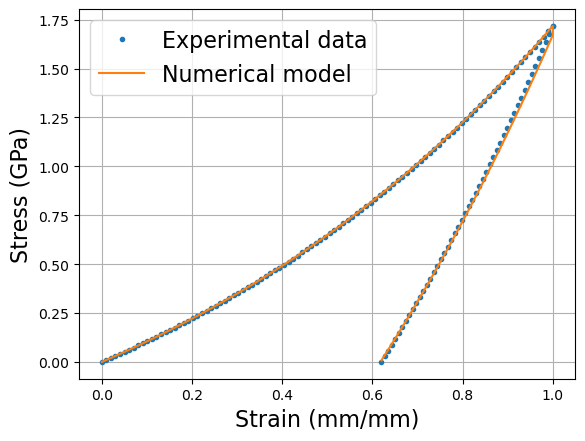

In [10]:
# plot the results
with torch.no_grad():
    num_data = model()
plt.figure()
plt.plot(exp_data[:, 0], exp_data[:, 1], '.', label='Experimental data')
plt.plot(num_data[:, 0], num_data[:, 1], '-', label='Numerical model')
plt.grid(True)
plt.xlabel('Strain (mm/mm)', fontsize=16)
plt.ylabel('Stress (GPa)', fontsize=16)
plt.legend(fontsize=16)
plt.show()